In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Imports**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.signal import periodogram, detrend
from statsmodels.tsa.stattools import acf

# **Loading the Dataset**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DS_Project_2025/DS_Project_Dataset/LTAR_LegProd_ANPP-PPT.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       333 non-null    int64  
 1   site.code  333 non-null    object 
 2   type       333 non-null    object 
 3   Crop       333 non-null    object 
 4   Cereal     333 non-null    object 
 5   MAP        333 non-null    float64
 6   ANPP       333 non-null    float64
 7   PPT        333 non-null    float64
 8   WUE        333 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 23.5+ KB


In [5]:
df.describe()

,year,MAP,ANPP,PPT,WUE
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,2007.729730,727.159780,6634.256580,706.566073,9.100012
std,9.470893,261.855849,5916.851971,281.395258,7.670801
min,1983.000000,263.137300,109.666667,115.310000,0.480846
25%,2002.000000,447.119999,1586.471111,499.110000,2.846039
50%,2009.000000,708.647165,5240.607768,729.740000,6.801348
75%,2015.000000,942.509580,9284.000000,922.000000,12.889326
max,2022.000000,1237.622148,30431.758530,1604.483978,47.485875


In [6]:
df.columns

Index(['year', 'site.code', 'type', 'Crop', 'Cereal', 'MAP', 'ANPP', 'PPT',
       'WUE'],
      dtype='object')

In [7]:
df_no_year_numeric = df.drop(columns = ['year', 'site.code', 'type', 'Crop', 'Cereal', 'MAP'])

# **Data Pre-Processing**

## **Skewness Analysis**

In [8]:
def compute_bins(data: np.ndarray, max_bins: int = 100) -> tuple:
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    n = len(data)
    bin_width = 2 * iqr * (n ** (-1/3)) if iqr > 0 else 1
    num_bins = max(1, int((data.max() - data.min()) / bin_width))
    num_bins = min(int(num_bins * 1.5), max_bins)
    bin_edges = np.linspace(data.min(), data.max(), num_bins + 1)
    return num_bins, bin_edges

In [9]:
def custom_xticks(ax, data: np.ndarray, is_anpp: bool = False):
    if is_anpp:
        tick_interval = 5000
        tick_start = int(data.min() // tick_interval * tick_interval)
        tick_end = int(data.max() // tick_interval * tick_interval + tick_interval)
    else:
        data_range = data.max() - data.min()
        tick_interval = data_range / 6
        tick_interval = round(tick_interval, -int(np.floor(np.log10(abs(tick_interval)))))
        tick_start = int(np.floor(data.min() / tick_interval)) * tick_interval
        tick_end = int(np.ceil(data.max() / tick_interval)) * tick_interval

    ticks = list(np.arange(tick_start, tick_end + tick_interval, tick_interval))

    # Ensure data.min() is shown explicitly
    if not np.any(np.isclose(ticks, data.min(), rtol=0, atol=1e-5)):
        ticks.append(data.min())

    ticks = sorted(set(ticks))
    ax.set_xticks(ticks)

In [10]:
def analyze_skewness(df: pd.DataFrame) -> None:
    skewness = df.apply(lambda x: skew(x, nan_policy='omit'))

    print("Skewness values for each variable:\n", skewness, '\n')

    for col in df.select_dtypes(include=[np.number]).columns:
        data = df[col].dropna()
        print(f"{col}: min={data.min()}, max={data.max()}, has NaNs={df[col].isna().any()}\n")

        num_bins, bin_edges = compute_bins(data)
        bin_width = (data.max() - data.min()) / num_bins
        print(f"Adjusted number of bins for {col}: {num_bins}")
        print(f"Bin width for {col}: {bin_width:.2f}\n")

        plt.figure(figsize=(8, 5))
        ax = sns.histplot(data, kde=True, bins=bin_edges, stat="count", edgecolor='black', linewidth=0.5)

        custom_xticks(ax, data, is_anpp=(col == 'ANPP'))
        ax.set_xlim(data.min(), data.max())
        ax.set_title(f'Distribution of {col}', fontsize=14, weight='bold')
        ax.set_xlabel(f'{col}', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        plt.tight_layout()
        plt.show()

        skew_value = skewness[col]
        if skew_value > 0.5:
            print(f"{col} is **positively skewed**\n")
        elif skew_value < -0.5:
            print(f"{col} is **negatively skewed**\n")
        else:
            print(f"{col} is approximately **normally distributed**\n")

Skewness values for each variable:
 ANPP    1.203434
PPT    -0.004480
WUE     1.280864
dtype: float64 

ANPP: min=109.6666667, max=30431.75853, has NaNs=False

Adjusted number of bins for ANPP: 19
Bin width for ANPP: 1595.90



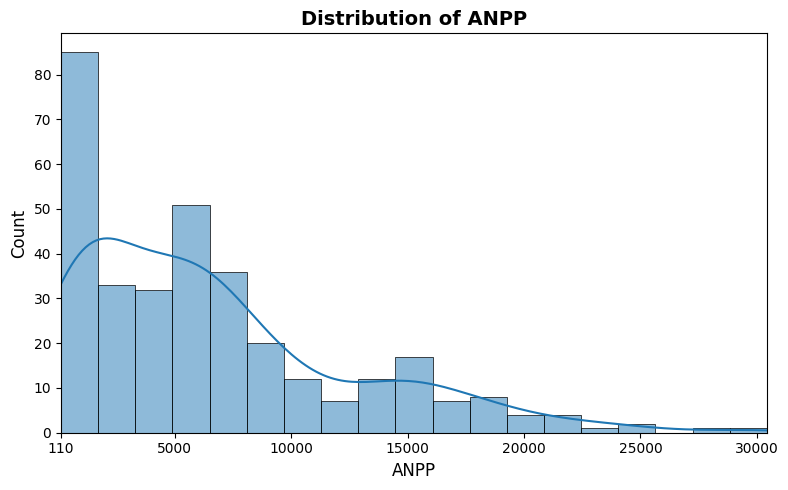

ANPP is **positively skewed**

PPT: min=115.31, max=1604.483978, has NaNs=False

Adjusted number of bins for PPT: 18
Bin width for PPT: 82.73



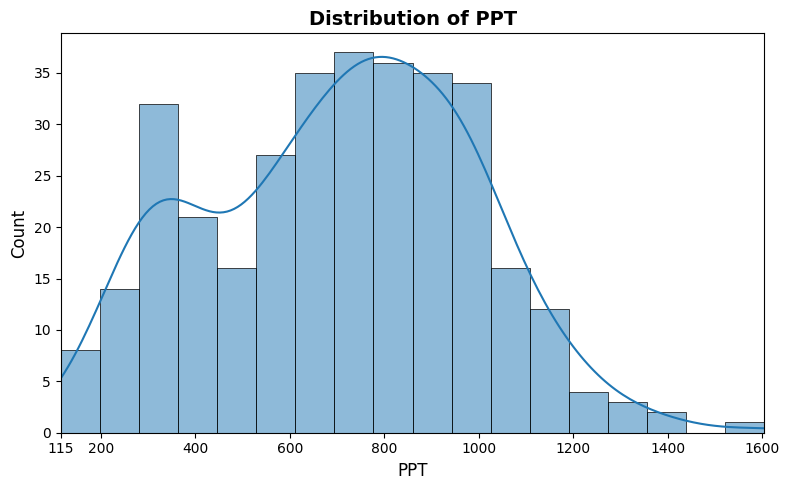

PPT is approximately **normally distributed**

WUE: min=0.480845753, max=47.48587534, has NaNs=False

Adjusted number of bins for WUE: 24
Bin width for WUE: 1.96



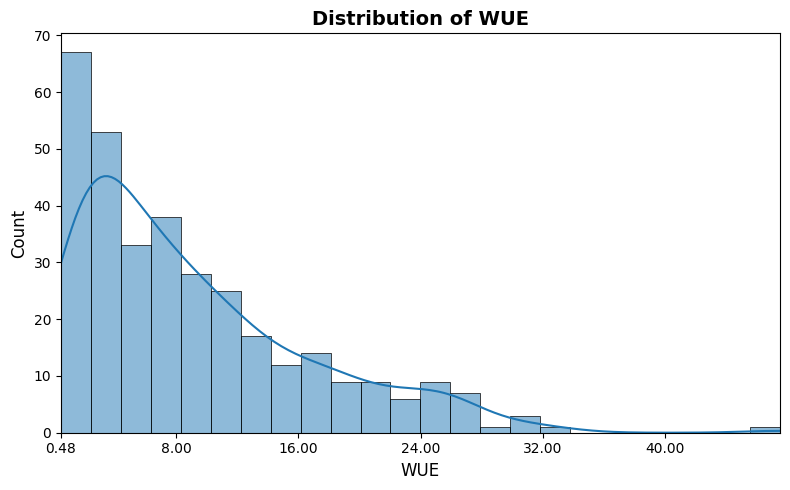

WUE is **positively skewed**



In [11]:
analyze_skewness(df_no_year_numeric)

# **Transformations**

In [12]:
def apply_transformation(data: pd.Series) -> tuple[pd.Series, str]:

    skewness = data.skew()
    if skewness > 1:  # Highly skewed, apply log transformation
        return np.log1p(data), 'log'
    elif skewness > 0.5:  # Moderately skewed, apply square root transformation
        return np.sqrt(data), 'sqrt'
    return data, 'none'

In [13]:
def transform_dataframe(df: pd.DataFrame, columns: list) -> tuple[pd.DataFrame, dict]:

    transformed_df = df.copy()
    transform_info = {}

    for col in columns:
        if (transformed_df[col] < 0).any():
            print(f"Column '{col}' contains negative values, which are not supported for transformation.")
            continue

        transformed_col, transform_type = apply_transformation(transformed_df[col])
        transformed_df[f"{col}_transformed"] = transformed_col
        transform_info[col] = transform_type

    return transformed_df, transform_info

In [14]:
columns_to_transform = ['ANPP', 'WUE']

df_transformed, df_transformed_info = transform_dataframe(df, columns_to_transform)


In [15]:
print("\nOriginal DataFrame:")
print(df)

print("\nTransformed DataFrame:")
print(df_transformed)


Original DataFrame:
     year site.code        type         Crop      Cereal         MAP  \
0    1983      CPER  Rangelands        Range       Range  318.750000   
1    1984      CPER  Rangelands        Range       Range  318.750000   
2    1984     PRHPA   Croplands        Maize      Cereal  702.199915   
3    1984     PRHPA   Croplands      Soybean  Non-Cereal  702.199915   
4    1985      CPER  Rangelands        Range       Range  318.750000   
..    ...       ...         ...          ...         ...         ...   
328  2022    GB_los  Rangelands        Range       Range  428.340687   
329  2022    GB_mbs  Rangelands        Range       Range  504.588187   
330  2022    GB_wbs  Rangelands        Range       Range  419.715687   
331  2022        TG     Pasture  Switchgrass     Pasture  913.819249   
332  2022        TG  Rangelands        Range       Range  913.819249   

            ANPP         PPT        WUE  
0    1019.342222  405.638000   2.512936  
1    1012.044444  384.788000  

# **Correlation Matrix**

In [16]:
def calculate_correlation(df: pd.DataFrame) -> pd.DataFrame:

  pearson_corr = df.corr(method='pearson')
  print("Pearson Correlation:\n", pearson_corr)

  spearman_corr = df.corr(method='spearman')
  print("\nSpearman Correlation:\n", spearman_corr)

  return pearson_corr, spearman_corr

In [17]:
def heatmaps_correlation(df: pd.DataFrame, correlation_method: str) -> None:

  plt.figure(figsize=(10, 6))

  sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
  plt.title(f"{correlation_method} Correlation Heatmap")

  plt.show()

In [18]:
df_transformed_no_year_numeric = df_transformed.drop(columns = ['year', 'site.code', 'type', 'Crop', 'Cereal', 'MAP'])

In [19]:
transformed_spearman_corr, transformed_pearson_corr = calculate_correlation(df_transformed_no_year_numeric)

Pearson Correlation:
                       ANPP       PPT       WUE  ANPP_transformed  \
ANPP              1.000000  0.379453  0.910364          0.861406   
PPT               0.379453  1.000000  0.095236          0.548104   
WUE               0.910364  0.095236  1.000000          0.797155   
ANPP_transformed  0.861406  0.548104  0.797155          1.000000   
WUE_transformed   0.873750  0.176753  0.929679          0.910823   

                  WUE_transformed  
ANPP                     0.873750  
PPT                      0.176753  
WUE                      0.929679  
ANPP_transformed         0.910823  
WUE_transformed          1.000000  

Spearman Correlation:
                       ANPP       PPT       WUE  ANPP_transformed  \
ANPP              1.000000  0.469814  0.932137          1.000000   
PPT               0.469814  1.000000  0.163386          0.469814   
WUE               0.932137  0.163386  1.000000          0.932137   
ANPP_transformed  1.000000  0.469814  0.932137          1

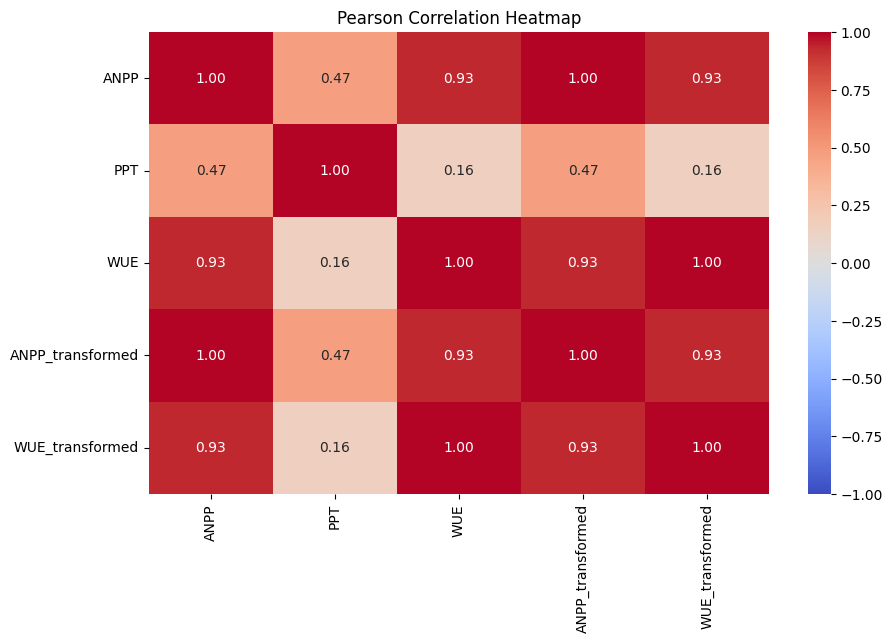

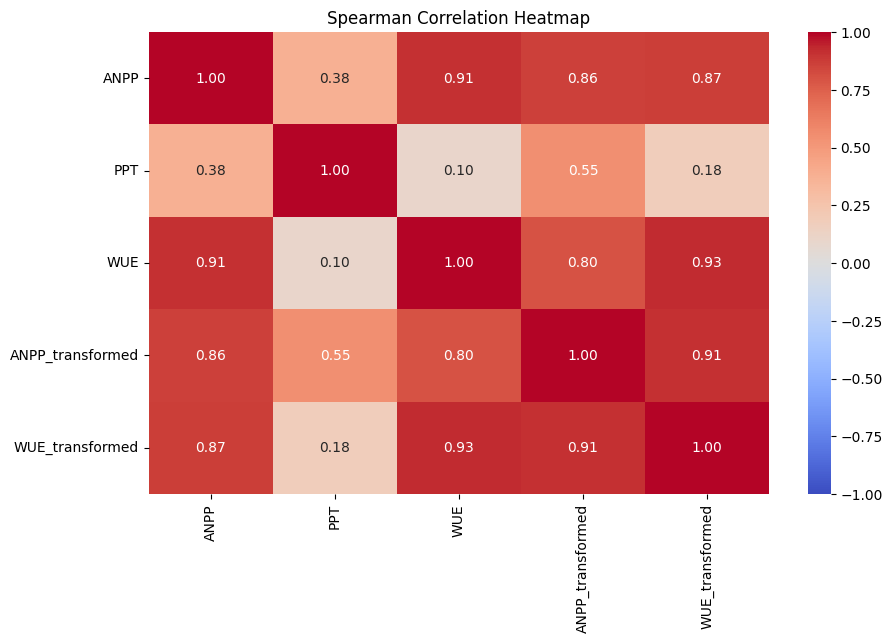

In [20]:
heatmaps_correlation(transformed_pearson_corr, 'Pearson')
heatmaps_correlation(transformed_spearman_corr, 'Spearman')

# **Outlier Detection**

In [21]:
sns.set_theme(style="whitegrid", palette="colorblind")

def detect_outliers(df: pd.DataFrame, column: str) -> dict:

    df = df.copy()
    data = df[column].dropna()

    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    mask = (df[column] < lower) | (df[column] > upper)
    outliers = df[mask]
    outlier_range = (outliers[column].min(), outliers[column].max()) if not outliers.empty else None

    print(f"\nIQR Method for {column}:")
    print(f"Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
    print(f"Lower Bound: {lower:.2f}, Upper Bound: {upper:.2f}")
    print(f"Number of IQR outliers: {len(outliers)}")
    print(f"Range of IQR outliers: {outlier_range if outlier_range else 'None'}")

    fig, ax = plt.subplots(figsize=(11, 5))

    sns.boxplot(x=df[column], ax=ax, color="#a6cee3", fliersize=0)
    sns.stripplot(x=df[column], ax=ax, color="#e31a1c", alpha=0.5, size=4, jitter=True)

    ax.axvline(q1, linestyle='--', color='gray', alpha=0.7)
    ax.axvline(q3, linestyle='--', color='gray', alpha=0.7)
    ax.axvspan(q1, q3, color="#b2df8a", alpha=0.2)

    ax.text(
        (q1 + q3) / 2,
        0.18,
        f'IQR Range:\n{q1:.2f} to {q3:.2f}',
        fontsize=11,
        ha='center',
        va='bottom',
        color='black',
        transform=ax.get_xaxis_transform()
    )

    if outlier_range:
        ax.axvspan(outlier_range[0], outlier_range[1], color="#fb9a99", alpha=0.3)
        ax.text(
            (outlier_range[0] + outlier_range[1]) / 2,
            0.05,
            f'Outlier Range:\n{outlier_range[0]:.2f} to {outlier_range[1]:.2f}',
            fontsize=11,
            ha='center',
            va='bottom',
            color='darkred',
            transform=ax.get_xaxis_transform()
        )

    ax.set_title(f'Outlier Detection in "{column}"', fontsize=16, weight='bold', pad=15)
    ax.set_xlabel(
        f'{column} values\n'
        '• Green area = Interquartile Range (Q1–Q3)\n'
        '• Red shaded = Outlier Range\n'
        '• Red dots = Observations (possible outliers beyond IQR)',
        fontsize=12,
        labelpad=12
    )
    ax.set_ylabel('')
    ax.set_xlim(data.min() - 0.05 * abs(data.min()), data.max() + 0.05 * abs(data.max()))
    ax.grid(True, axis='x', linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

    return {
        'iqr_outliers': outliers,
        'cleaned_df': df[~mask]
    }


IQR Method for ANPP:
Q1: 1586.47, Q3: 9284.00, IQR: 7697.53
Lower Bound: -9959.82, Upper Bound: 20830.29
Number of IQR outliers: 9
Range of IQR outliers: (21168.0, 30431.75853)


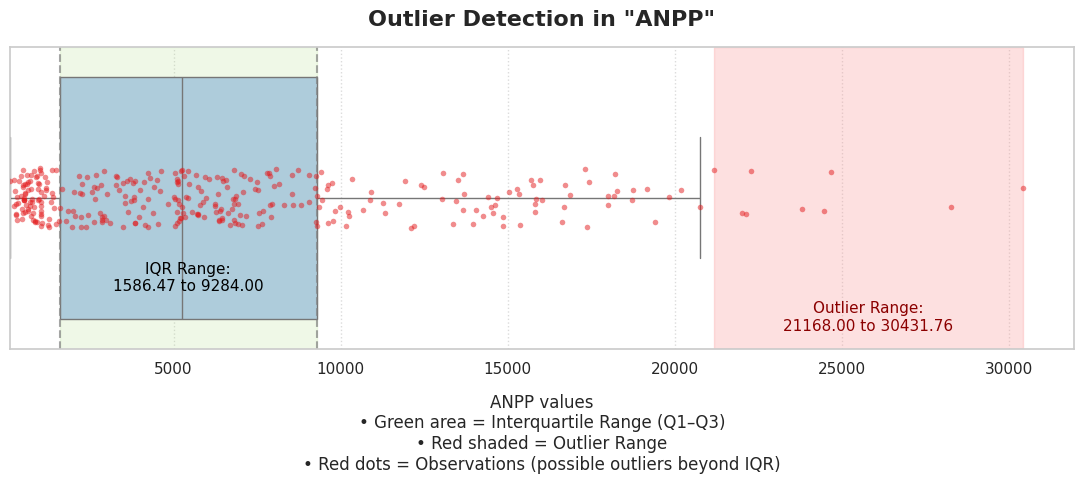

In [22]:
outlier_results = detect_outliers(df, 'ANPP')

In [23]:
iqr_outliers = outlier_results['iqr_outliers']

print(iqr_outliers)

     year site.code       type   Crop  Cereal         MAP         ANPP  \
84   2002      UMRB  Croplands  Maize  Cereal  859.391183  22004.41904   
127  2006      UMRB  Croplands  Maize  Cereal  859.391183  22283.97584   
153  2008      UMRB  Croplands  Maize  Cereal  859.391183  23822.66978   
183  2010      UMRB  Croplands  Maize  Cereal  859.391183  24477.38693   
198  2011        NH  Croplands  Maize  Cereal  876.582752  22120.29747   
213  2012      UMRB  Croplands  Maize  Cereal  859.391183  24683.91778   
251  2015        NH  Croplands  Maize  Cereal  876.582752  30431.75853   
285  2018       ECB  Croplands  Maize  Cereal  912.840025  21168.00000   
296  2018        NH  Croplands  Maize  Cereal  876.582752  28261.72354   

             PPT        WUE  
84    719.700000  30.574432  
127   729.342000  30.553534  
153   877.570000  27.146176  
183  1145.021840  21.377223  
198   865.890993  25.546284  
213   519.816000  47.485875  
251   982.618000  30.970080  
285   930.071800  2

In [24]:
df_cleaned = outlier_results['cleaned_df']
print(df_cleaned.head(5))

   year site.code        type     Crop      Cereal         MAP         ANPP  \
0  1983      CPER  Rangelands    Range       Range  318.750000  1019.342222   
1  1984      CPER  Rangelands    Range       Range  318.750000  1012.044444   
2  1984     PRHPA   Croplands    Maize      Cereal  702.199915  9976.402500   
3  1984     PRHPA   Croplands  Soybean  Non-Cereal  702.199915  4144.737500   
4  1985      CPER  Rangelands    Range       Range  318.750000   836.469841   

          PPT        WUE  
0  405.638000   2.512936  
1  384.788000   2.630135  
2  790.195001  12.625241  
3  790.195001   5.245208  
4  303.122000   2.759515  


In [25]:
columns_to_transform = ['ANPP', 'WUE']

df_processed, df_processed_info = transform_dataframe(df_cleaned, columns_to_transform)

print("\nOriginal DataFrame:")
print(df)

print("\nTransformed DataFrame:")
print(df_processed)


Original DataFrame:
     year site.code        type         Crop      Cereal         MAP  \
0    1983      CPER  Rangelands        Range       Range  318.750000   
1    1984      CPER  Rangelands        Range       Range  318.750000   
2    1984     PRHPA   Croplands        Maize      Cereal  702.199915   
3    1984     PRHPA   Croplands      Soybean  Non-Cereal  702.199915   
4    1985      CPER  Rangelands        Range       Range  318.750000   
..    ...       ...         ...          ...         ...         ...   
328  2022    GB_los  Rangelands        Range       Range  428.340687   
329  2022    GB_mbs  Rangelands        Range       Range  504.588187   
330  2022    GB_wbs  Rangelands        Range       Range  419.715687   
331  2022        TG     Pasture  Switchgrass     Pasture  913.819249   
332  2022        TG  Rangelands        Range       Range  913.819249   

            ANPP         PPT        WUE  
0    1019.342222  405.638000   2.512936  
1    1012.044444  384.788000  

# **Filtering**

In [26]:
def filter_df(df, column_name, custom_value):
    custom_df = df[df[column_name] == custom_value]
    return custom_df

# **Exploratory Data Analysis**

### **Time Series Analysis**

**Fills in missing years and long term trend removal:**

*   Take yearly data and makes sure all years are included by filling gaps with straight-line guesses (linear interpolation)
*   Remove any overall upward or downward trend so we can focus on repeating patterns.

In [27]:
def prepare_time_series(df, time_col, value_col):

    '''Fill missing years with linear interpolation and detrend data.'''

    df_clean = df[[time_col, value_col]].dropna().sort_values(time_col)

    min_year = int(df_clean[time_col].min())
    max_year = int(df_clean[time_col].max())
    all_years = np.arange(min_year, max_year + 1)
    df_full = pd.DataFrame({time_col: all_years})
    df_full = df_full.merge(df_clean, on=time_col, how='left')

    df_full[value_col] = df_full[value_col].interpolate(method='linear').bfill().ffill()
    data = df_full[value_col].values
    n = len(data)

    data_detrended = detrend(data, type='linear')

    return df_full, data_detrended, n

**Cycles Detection**
  
For data repeating every 5 years by analyzing the data’s strength a different time periods. It picks the strongest cycle within chosen range (2 to 10 years).
    
**Formula:** Uses a periodogram, which breaks data into frequencies (how often it repeats).    

*   Period = 1 / Frequency (e.g., frequency of 0.2 means a 5-year cycle).
*   Picks the period with the highest “power” (strength).



In [28]:
def detect_cycles(data_detrended, n, min_period, max_period=None):

    '''Find dominant cycle using periodogram.'''

    if n < 5:
        print(f"Small dataset (n={n}). Cycle detection may be unreliable.")

    fs = 1.0  # Yearly sampling
    frequencies, power = periodogram(data_detrended, fs=fs, scaling='density')
    periods = np.zeros_like(frequencies)
    periods[frequencies != 0] = 1 / frequencies[frequencies != 0]
    periods[frequencies == 0] = np.inf

    max_period = max_period if max_period is not None else n / 2

    valid_idx = np.where((periods >= min_period) & (periods <= max_period))[0]
    if len(valid_idx) == 0:
        return None, frequencies, power

    dominant_idx = valid_idx[np.argmax(power[valid_idx])]
    cycle_period = periods[dominant_idx]
    if np.isinf(cycle_period) or cycle_period < min_period or cycle_period > max_period:
        return None, frequencies, power

    return cycle_period, frequencies, power

**Checks if this year’s data is related to past years**
    
Identifies the strong connection years where current data depends on the data from 1, 2, or more years ago
    
**Formula:** Uses autocorrelation (ACF), which measures how similar data is to itself at different time lags (e.g., lag 1 = 1 year ago).


*   Correlation = (sum of (data at time t) * (data at time t-lag)) / (data variance).
*   Marks lags where correlation is significantly high.

In [29]:
def detect_autocorrelation(data_detrended, n, max_lags):

    '''Find significant autocorrelation lags using ACF.'''

    max_lags = min(max_lags, n // 2)
    if max_lags < 1:
        return []

    acf_vals, acf_confint = acf(data_detrended, nlags=max_lags, fft=False, alpha=0.05)
    significant_lags = [
        lag for lag in range(1, max_lags + 1)
        if not (acf_confint[lag][0] <= acf_vals[lag] <= acf_confint[lag][1])
    ]
    return significant_lags

**Checks if PPT affects ANPP after a delay**
       
**Formula:** Uses cross-correlation, which measures how similar two variables are when one is shifted by a lag PPT (2 years ago) vs. ANPP (current year)



*  Correlation = (sum of (y at time t) * (x at time t-lag)) / (y variance * x variance).
*  Marks lags where correlation is significantly high.

In [30]:
def detect_cross_lagged_effects(y_detrended, x_detrended, n, max_lags):

    ''' Find significant cross-lagged effects between two series. '''

    max_lags = min(max_lags, n // 2)
    if max_lags < 1:
        return [], np.array([])

    # Compute cross-correlations
    cross_corrs = np.zeros(max_lags + 1)
    for lag in range(max_lags + 1):
        if lag == 0:
            corr = np.corrcoef(y_detrended, x_detrended)[0, 1]
        else:
            corr = np.corrcoef(y_detrended[lag:], x_detrended[:-lag])[0, 1] if lag < n else 0
        cross_corrs[lag] = corr if not np.isnan(corr) else 0

    # Determine significance
    se = 1 / np.sqrt(n - np.arange(max_lags + 1) - 3)
    ci = 1.96 * se
    cross_lagged_lags = [
        lag for lag in range(max_lags + 1)
        if abs(cross_corrs[lag]) > ci[lag]
    ]
    return cross_lagged_lags, cross_corrs

In [31]:
def plot_time_series(df, time_col, value_col, data_detrended, cycle_period):

    ''' Plot detrended time series with cycle info.'''

    plt.figure(figsize=(10, 4))
    plt.plot(df[time_col], data_detrended, marker='o', linestyle='-', color='blue', label='Detrended Data')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    title = (f'{value_col} Time Series (Detrended, Interpolated) - '
             f'Cycle: {cycle_period:.1f} years' if cycle_period else
             f'{value_col} Time Series (Detrended, Interpolated) - No Cycle Detected')
    plt.title(title, fontsize=12)
    plt.xlabel(time_col)
    plt.ylabel(value_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [32]:
def plot_periodogram(value_col, frequencies, power, cycle_period, min_period, max_period=None):

    '''Plot periodogram with dominant cycle'''

    periods = np.zeros_like(frequencies)
    mask = frequencies != 0
    periods[mask] = 1 / frequencies[mask]
    periods[~mask] = np.inf

    max_period = max_period or max(periods[periods != np.inf])
    valid_mask = (periods >= min_period) & (periods <= max_period)
    valid_periods = periods[valid_mask]
    valid_power = power[valid_mask]

    if len(valid_periods) == 0:
        print(f"No valid periods for {value_col} in range {min_period} to {max_period} years.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(valid_periods, valid_power, color='blue', label='Power Spectrum')

    if cycle_period:
        plt.axvline(cycle_period, color='red', linestyle='--', alpha=0.7, label=f'Dominant Cycle: {cycle_period:.1f} years')
    if cycle_period:
        max_display_period = min(max_period, max(cycle_period * 2, 10))
        plt.xlim(min_period, max_display_period)
    else:
        plt.xlim(min_period, max_period)

    plt.yscale('log')
    plt.ylim(bottom=1e-1)
    plt.title(f'Periodogram for {value_col}', fontsize=12)
    plt.xlabel('Period (years)')
    plt.ylabel('Power (log scale)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [33]:
def plot_cross_lagged(value_col, predictor_col, cross_corrs, cross_lagged_lags):

    ''' Plot cross-lagged correlations. '''

    lags = np.arange(len(cross_corrs))
    plt.figure(figsize=(10, 4))
    plt.bar(lags, cross_corrs, color='blue', alpha=0.6, label='Cross-Correlation')
    if cross_lagged_lags:
        for lag in cross_lagged_lags:
            plt.bar(lag, cross_corrs[lag], color='red', alpha=0.8, label='Significant Lag' if lag == cross_lagged_lags[0] else '')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Cross-Lagged Correlations: {value_col} vs {predictor_col}', fontsize=12)
    plt.xlabel('Lag (years)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [34]:
def analyze_time_series(df, value_col, time_col='year', predictor_col=None, max_lags=5, min_period=2, max_period=None, plot=True, time_series_analysis_name=None):

    ''' Analyze time series for cycles and lagged effects. '''

    print(f"Starting analysis for {value_col} with predictor {predictor_col}")

    # Prepare data
    df_clean, data_detrended, n = prepare_time_series(df, time_col, value_col)

    # Detect cycles
    cycle_period, frequencies, power = detect_cycles(data_detrended, n, min_period, max_period)

    # Detect autocorrelation
    significant_lags = detect_autocorrelation(data_detrended, n, max_lags)

    # Detect cross-lagged effects
    cross_lagged_lags = []
    cross_corrs = np.array([])
    if predictor_col:
        df_predictor, predictor_detrended, _ = prepare_time_series(df, time_col, predictor_col)
        cross_lagged_lags, cross_corrs = detect_cross_lagged_effects(data_detrended, predictor_detrended, n, max_lags)

    if plot:
        plot_time_series(df_clean, time_col, value_col, data_detrended, cycle_period)
        plot_periodogram(value_col, frequencies, power, cycle_period, min_period, max_period)
        if predictor_col and len(cross_corrs) > 0:
            plot_cross_lagged(value_col, predictor_col, cross_corrs, cross_lagged_lags)

    messages = []
    if cycle_period:
        messages.append(f"Dominant cycle detected at {cycle_period:.1f}-year period.")
    else:
        messages.append(f"No significant cycle detected ({min_period}–{max_period or 'n/2'} years).")
    if significant_lags:
        messages.append(f"Significant autocorrelation at lags: {significant_lags}.")
    else:
        messages.append(f"No significant autocorrelation detected (lags 1–{max_lags}).")
    if predictor_col:
        if cross_lagged_lags:
            messages.append(f"Significant cross-lagged effects ({value_col} vs. {predictor_col}) at lags: {cross_lagged_lags}.")
        else:
            messages.append(f"No significant cross-lagged effects ({value_col} vs. {predictor_col}) detected (lags 0–{max_lags}).")

    return {
        'cycle_period': cycle_period,
        'significant_lags': significant_lags,
        'cross_lagged_lags': cross_lagged_lags,
        'message': ' '.join(messages),
        'n_points': n,
        'name': 'time_series_analysis_name'
    }

### **Correlation Analysis**

*   **Pearson:** straight-line relationship
*   **Spearman:** checks for a consistent trend

In [35]:
def calculate_correlations(df, col1, col2):

    pearson_corr = df[col1].corr(df[col2])
    spearman_corr = df[[col1, col2]].corr(method='spearman').iloc[0, 1]

    print(f"Correlation between {col1} and {col2} (Pearson): {pearson_corr:.3f}")
    print(f"Correlation between {col1} and {col2} (Spearman): {spearman_corr:.3f}")

    return pearson_corr, spearman_corr

### **Exploratory Analysis of Unique Values**

In [36]:
def explore_column_values(df, columns):

    ''' Displays unique values and their counts for specified columns as part of EDA. '''

    for col in columns:
        print(f"\nUnique values in '{col}':")
        print(df[col].value_counts())
        print("\n" + "="*50 + "\n")

In [37]:
df_processed.columns

Index(['year', 'site.code', 'type', 'Crop', 'Cereal', 'MAP', 'ANPP', 'PPT',
       'WUE', 'ANPP_transformed', 'WUE_transformed'],
      dtype='object')

In [38]:
explore_column_values(df_processed, ['Crop', 'type', 'site.code', 'Cereal'])


Unique values in 'Crop':
Crop
Range           98
Maize           60
Soybean         60
Switchgrass     40
Winter_Wheat    23
Spring_Wheat    20
Alfalfa         10
Mixed_grass      9
Oats             2
Garbanzo         1
Canola           1
Name: count, dtype: int64



Unique values in 'type':
type
Croplands     167
Rangelands     98
Pasture        59
Name: count, dtype: int64



Unique values in 'site.code':
site.code
PRHPA     90
CPER      37
UCB       36
KBS       32
TG        26
NP        18
JER       13
LCB       12
UMRB       9
GB_wbs     8
GB_los     8
GB_mbs     8
NH         6
CAF        6
SP         6
ABS-UF     5
ECB        4
Name: count, dtype: int64



Unique values in 'Cereal':
Cereal
Cereal        105
Range          98
Non-Cereal     62
Pasture        59
Name: count, dtype: int64


